In [1]:
import numpy as np
import pickle
import cv2
from os import listdir
from sklearn.preprocessing import LabelBinarizer
from keras.models import Sequential
from keras.layers import BatchNormalization, Conv2D, MaxPooling2D
from keras.layers import Activation, Flatten, Dropout, Dense
from keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.preprocessing import image
from keras.preprocessing.image import img_to_array
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
EPOCHS = 25
INIT_LR = 1e-3
BS = 32
default_image_size = tuple((256, 256))
directory_root = './mpt2/'
width = 256
height = 256
depth = 3

In [3]:
def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None:
            image = cv2.resize(image, default_image_size)
            return img_to_array(image)
        else:
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None


In [4]:
image_list, label_list = [], []
try:
    print("[INFO] Loading images ...")
    root_dir = listdir(directory_root)
    for directory in root_dir:
        if directory == ".DS_Store":
            root_dir.remove(directory)

    for plant_folder in root_dir:
        plant_disease_folder_list = listdir(f"{directory_root}/{plant_folder}")

        for disease_folder in plant_disease_folder_list:
            if disease_folder == ".DS_Store":
                plant_disease_folder_list.remove(disease_folder)

        for plant_disease_folder in plant_disease_folder_list:
            print(f"[INFO] Processing {plant_disease_folder} ...")
            plant_disease_image_list = listdir(f"{directory_root}/{plant_folder}/{plant_disease_folder}/")

            for single_plant_disease_image in plant_disease_image_list:
                if single_plant_disease_image == ".DS_Store":
                    plant_disease_image_list.remove(single_plant_disease_image)

            for image in plant_disease_image_list[:200]:
                image_directory = f"{directory_root}/{plant_folder}/{plant_disease_folder}/{image}"
                if image_directory.endswith(".jpg") or image_directory.endswith(".JPG"):
                    image_list.append(convert_image_to_array(image_directory))
                    label_list.append(plant_disease_folder)
    print("[INFO] Image loading completed")
except Exception as e:
    print(f"Error : {e}")


[INFO] Loading images ...
[INFO] Processing Apple Black rot ...
[INFO] Processing Apple Healthy ...
[INFO] Processing Apple rust Cedar ...
[INFO] Processing Apple Scab ...
[INFO] Processing Bell pepper Bacterial spot ...
[INFO] Processing Bell pepper Healthy ...
[INFO] Processing Citrus Black spot ...
[INFO] Processing Citrus canker ...
[INFO] Processing Citrus greening ...
[INFO] Processing Citrus Healthy ...
[INFO] Processing Corn Common rust ...
[INFO] Processing Corn Gray leaf spot ...
[INFO] Processing Corn Healthy ...
[INFO] Processing Corn Northern Leaf Blight ...
[INFO] Processing Grape Black Measles ...
[INFO] Processing Grape Black rot ...
[INFO] Processing Grape Healthy ...
[INFO] Processing Grape Isariopsis Leaf Spot ...
[INFO] Processing Peach Bacterial spot ...
[INFO] Processing Peach Healthy ...
[INFO] Processing Potato Early blight ...
[INFO] Processing Potato Healthy ...
[INFO] Processing Potato Late blight ...
[INFO] Processing Strawberry Healthy ...
[INFO] Processing

In [5]:
label_binarizer = LabelBinarizer()
image_labels = label_binarizer.fit_transform(label_list)
pickle.dump(label_binarizer, open('labels.pkl', 'wb'))
n_classes = len(label_binarizer.classes_)

In [6]:
np_image_list = np.array(image_list, dtype=np.float16) / 255.0

In [7]:
print("[INFO] Splitting data to train and test sets")
x_train, x_test, y_train, y_test = train_test_split(np_image_list, image_labels, test_size=0.25, random_state=42)


[INFO] Splitting data to train and test sets


In [8]:
aug = ImageDataGenerator(
    rotation_range=30, 
    width_shift_range=0.2,
    height_shift_range=0.2, 
    shear_range=0.2,
    zoom_range=0.2, 
    horizontal_flip=True, 
    fill_mode="nearest"
)

In [9]:
model = Sequential()
inputShape = (height, width, depth)
chanDim = -1
if K.image_data_format() == "channels_first":
    inputShape = (depth, height, width)
    chanDim = 1

model.add(Conv2D(32, (3, 3), padding="same", input_shape=inputShape))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(1024))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(n_classes))
model.add(Activation("softmax"))

model.summary()

c:\Users\indla\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 256, 256, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 256, 256, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256, 256, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 85, 85, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 85, 85, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 85, 85, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 85, 85, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 85, 85, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 85, 85, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 85, 85, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 85, 85, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 42, 42, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 42, 42, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 42, 42, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 42, 42, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 42, 42, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 42, 42, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 42, 42, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 42, 42, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 21, 21, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 21, 21, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 56448)          │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 58,123,171 (221.72 MB)

 Trainable params: 58,120,291 (221.71 MB)

 Non-trainable params: 2,880 (11.25 KB)

In [10]:
model = Sequential()
inputShape = (height, width, depth)
chanDim = -1
if K.image_data_format() == "channels_first":
    inputShape = (depth, height, width)
    chanDim = 1

model.add(Conv2D(32, (3, 3), padding="same", input_shape=inputShape))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(1024))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(n_classes))
model.add(Activation("softmax"))

model.summary()

c:\Users\indla\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


In [11]:
print("[INFO] Training network...")
history = model.fit(
    aug.flow(x_train, y_train, batch_size=BS),
    validation_data=(x_test, y_test),
    steps_per_epoch=len(x_train) // BS,
    epochs=EPOCHS, verbose=1
)

[INFO] Training network...
Epoch 1/25


c:\Users\indla\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


155/155 ━━━━━━━━━━━━━━━━━━━━ 391s 2s/step - accuracy: 0.2161 - loss: 3.3278 - val_accuracy: 0.0434 - val_loss: 14.2589
Epoch 2/25
  1/155 ━━━━━━━━━━━━━━━━━━━━ 5:10 2s/step - accuracy: 0.4062 - loss: 1.9741

c:\Users\indla\AppData\Local\Programs\Python\Python312\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


155/155 ━━━━━━━━━━━━━━━━━━━━ 18s 104ms/step - accuracy: 0.4062 - loss: 1.9741 - val_accuracy: 0.0452 - val_loss: 14.2676
Epoch 3/25
155/155 ━━━━━━━━━━━━━━━━━━━━ 289s 2s/step - accuracy: 0.4095 - loss: 2.2477 - val_accuracy: 0.1055 - val_loss: 9.8676
Epoch 4/25
155/155 ━━━━━━━━━━━━━━━━━━━━ 14s 77ms/step - accuracy: 0.5000 - loss: 1.6432 - val_accuracy: 0.1073 - val_loss: 9.5946
Epoch 5/25
155/155 ━━━━━━━━━━━━━━━━━━━━ 285s 2s/step - accuracy: 0.4783 - loss: 1.9031 - val_accuracy: 0.1965 - val_loss: 7.2652
Epoch 6/25
155/155 ━━━━━━━━━━━━━━━━━━━━ 14s 80ms/step - accuracy: 0.6250 - loss: 1.4272 - val_accuracy: 0.1953 - val_loss: 7.1843
Epoch 7/25
155/155 ━━━━━━━━━━━━━━━━━━━━ 282s 2s/step - accuracy: 0.5777 - loss: 1.4559 - val_accuracy: 0.5081 - val_loss: 2.0153
Epoch 8/25
155/155 ━━━━━━━━━━━━━━━━━━━━ 14s 78ms/step - accuracy: 0.6250 - loss: 1.2777 - val_accuracy: 0.4714 - val_loss: 2.2752
Epoch 9/25
155/155 ━━━━━━━━━━━━━━━━━━━━ 322s 2s/step - accuracy: 0.6055 - loss: 1.3715 - val_accuracy:

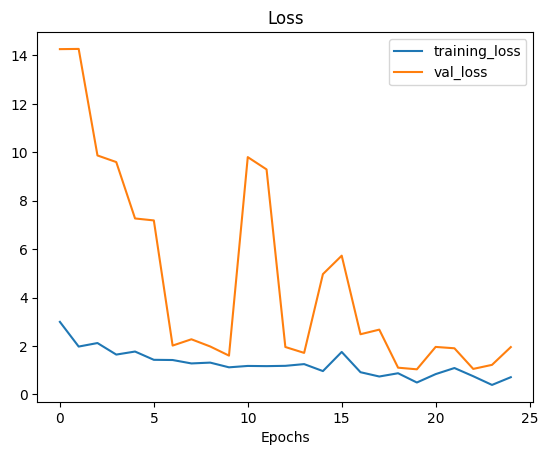

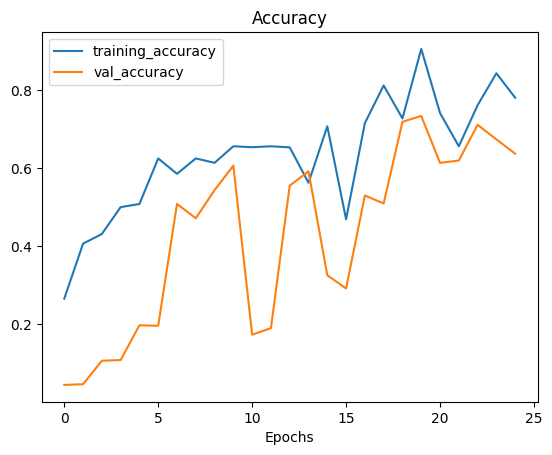

In [12]:
def plot_loss_curves(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    accuracy = history.history["accuracy"]
    val_accuracy = history.history['val_accuracy']
    epochs = range(len(history.history['loss']))

    plt.plot(epochs, loss, label='training_loss')
    plt.plot(epochs, val_loss, label='val_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    plt.figure()
    plt.plot(epochs, accuracy, label='training_accuracy')
    plt.plot(epochs, val_accuracy, label='val_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend()

plot_loss_curves(history)

In [13]:
scores = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {scores[1]*100}")

52/52 ━━━━━━━━━━━━━━━━━━━━ 14s 264ms/step - accuracy: 0.6310 - loss: 1.9510
Test Accuracy: 63.71307969093323


52/52 ━━━━━━━━━━━━━━━━━━━━ 14s 263ms/step


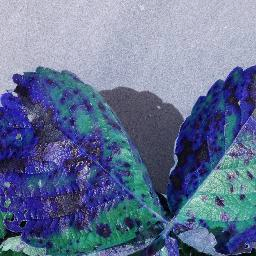

In [14]:
import tensorflow as tf
y_pred = model.predict(x_test)
img = tf.keras.preprocessing.image.array_to_img(x_test[1])
img

In [15]:
print("Originally : ",label_binarizer.classes_[np.argmax(y_test[1])])
print("Predicted : ",label_binarizer.classes_[np.argmax(y_pred[1])])

Originally :  Strawberry Leaf scorch
Predicted :  Strawberry Leaf scorch


In [16]:
model.save('saved_model.h5')
print("Model saved to disk.")

Model saved to disk.
